In [67]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import * 

In [68]:
# MILESTONE 1: Loading images
nibimgs = []
nibhdrs = []
filenames = []
for file,subdir,d in os.walk(os.getcwd()):
    if 'analyze' in file:
        filenames.append(file)
        a =[x for x in d if 'img' in x][0]
        imgpath = (os.path.join(file,a))
        nibimgs.append(imgpath)
        b = [x for x in d if 'hdr' in x][0]
        hdrpath = os.path.join(file,b)
        nibhdrs.append(hdrpath)
imgs = []
trainings_nonsegs = []
trainings_segs = []
validations_nonsegs = []
validations_segs = []
testings_nonsegs = []
testings_segs = []
for file in nibimgs:
    img = nib.load(file)
    hdr = img.header
    data = img.get_fdata()
    x,y,z = data.squeeze().shape
    middle_coronal = np.rot90(data[:,:,z//2],3)
    imgs.append(middle_coronal)
    if 'training' in file.lower():
        if 'segmentation' in file.lower():
            trainings_segs.append(middle_coronal)
        else:
            trainings_nonsegs.append(middle_coronal)
    elif 'testing' in file.lower():
        if 'segmentation' in file.lower():
            testings_segs.append(middle_coronal)
        else:
            testings_nonsegs.append(middle_coronal)
    elif 'validation' in file.lower():
        if 'segmentation' in file.lower():
            validations_segs.append(middle_coronal)
        else:
            validations_nonsegs.append(middle_coronal)
    else:
        raise ValueError ('Unidentifiable image: ',file)

In [69]:
def normalize(x):
    return x / np.max(x)

def geometric_transform(img, scale,theta,tx,ty,output_grid_shape):
    '''
    img (ndarray): 2-D img of floats
    scale (float): global expand/shrink, same positive factor applied on both axes
    theta (float): angle of rotation in degrees (ccw)
    tx (int): x-translation, assuming x is horizontal w.r.t user (right)
    ty (int): y-translation, assuming y is perpendicular to ground plane of user (downwards)
    '''
#     if scale < 0: 
#         raise UserWarning ('Turning scale to positive')
    if np.max(img) >= 1:
        img = normalize(img)
    shifted = shift(rotate(zoom(img.squeeze(),abs(scale)), theta) ,[ty,tx])
    
    ox, oy = shifted.shape[0]//2, shifted.shape[1]//2
    xdim = shifted.shape[0] - output_grid_shape[0]
    ydim = shifted.shape[1] - output_grid_shape[1]
    if xdim < 0: 
        xdim = abs(xdim)
        shifted = np.pad(shifted,((int(np.ceil(xdim/2)),int(np.floor(xdim/2))),(0,0)),mode='constant',constant_values=0)
    if ydim < 0: 
        ydim = abs(ydim)
        shifted = np.pad(shifted,((0,0),(int(np.ceil(ydim/2)),int(np.floor(ydim/2)))),mode='constant',constant_values=0)
    returned = shifted[max(0,ox-output_grid_shape[0]//2):max(ox+output_grid_shape[0]//2,output_grid_shape[0]),
                       max(0,oy-output_grid_shape[1]//2):max(oy+output_grid_shape[1]//2,output_grid_shape[1])]
    if returned.shape[0] != output_grid_shape[0] or returned.shape[1] != output_grid_shape[1]:
        print ('ERROR')
        print (shifted.shape)
        print (xdim, ydim)
        print (returned.shape)
        print (output_grid_shape)
    assert returned.shape[0] == output_grid_shape[0] and returned.shape[1] == output_grid_shape[1]
    return returned.shape, returned

## Test the Geometric Transform Works

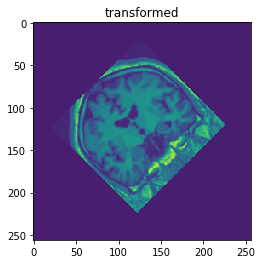

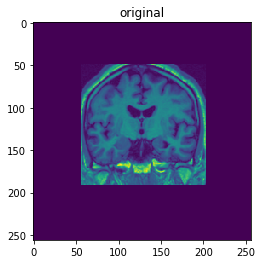

In [70]:
test = geometric_transform(imgs[0].squeeze(),scale=1,theta=45,tx=0,ty=0,output_grid_shape=(256,256))
plt.figure()
plt.title('transformed')
plt.imshow(test[1])
plt.figure()
plt.title('original')
plt.imshow(imgs[0].squeeze())

In [71]:
def SSD(transform,fixed,moving):
    if not len(transform) == 4:
        raise InvalidArgumentError
    moving = moving.squeeze()
    transformed_fixed = geometric_transform(fixed.squeeze(),transform[0],transform[1],transform[2],transform[3],fixed.squeeze().shape)[1]
    return np.sum((transformed_fixed - moving)**2)

In [72]:
from scipy.optimize import fmin,fmin_powell  # uses simplex method, derivative-free
def optimize(fixed,moving,initial_guess=None,**kwargs):
    if initial_guess is None:
        initial_guess = np.array([1.2,0.01,0.01,0.01])
    optimal = fmin_powell(func=SSD,x0=initial_guess,args=(fixed,moving),disp=True,maxiter=1e3,xtol=1e-7)
#     print ('\nOptimal parameters :')
    print (optimal)
    print ('='*60)
    return geometric_transform(fixed,optimal[0],optimal[1],optimal[2],optimal[3],fixed.shape)[1], optimal


## Test that the Registration Works

In [73]:
testscale = 1.2
testtheta = 40
testx = 15
testy = 25
testval = geometric_transform(imgs[0],testscale,testtheta,testx,testy,imgs[0].shape)[1]
init = np.array([1,0,0,0])
optimal_transform, params = optimize(imgs[0],testval,initial_guess=init)

C:\Users\shubh\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 1740
[ 1.19730515 40.         15.         25.        ]


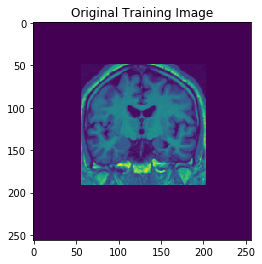

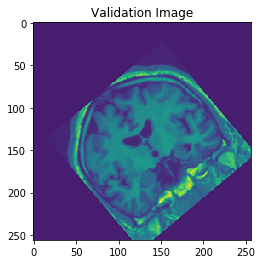

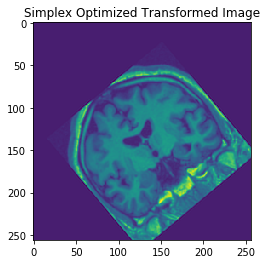

In [74]:

plt.figure()
plt.xticks(np.arange(0,501,50))
plt.yticks(np.arange(0,501,50))
plt.title('Original Training Image')
plt.imshow(imgs[0].squeeze())

plt.figure()
plt.xticks(np.arange(0,501,50))
plt.yticks(np.arange(0,501,50))
plt.title('Validation Image')
plt.imshow(testval.squeeze())

plt.figure()
plt.xticks(np.arange(0,501,50))
plt.yticks(np.arange(0,501,50))
plt.title('Simplex Optimized Transformed Image')
plt.imshow(optimal_transform)

## Training Image Registration

In [75]:
def jaccard(manual, automatic):
    '''
    Manual, automatic ndarray
    roi1, roi2 (iterable, list-like) if no roi2 then assume say indices for both images are ROI [xs,ys]
    '''
    if len(manual.shape) > 2:
        manual = manual.squeeze()
    if len(automatic.shape) > 2: 
        automatic = automatic.squeeze()
    manual_roi = np.where(manual == 1)
    added = manual + automatic
    union = len(np.where(added != 0)[0])
    intersection = len(np.where(added == 2)[0])
    return intersection / union

print (jaccard(np.ones((2,2)),np.ones((2,2)))) # sanity check

1.0


C:\Users\shubh\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Optimization terminated successfully.
         Current function value: 638.398791
         Iterations: 3
         Function evaluations: 304
[-0.90732937 -0.12361573 -0.59113717  1.36386189]


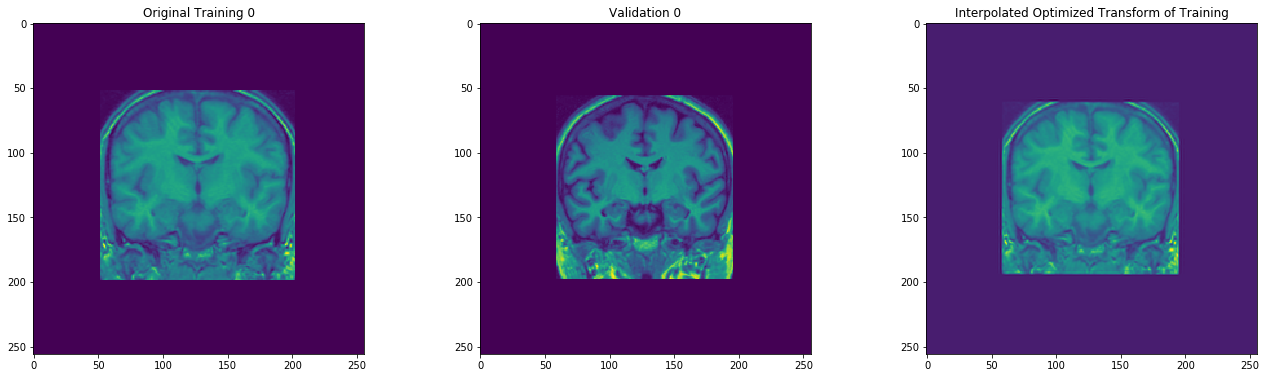

Optimization terminated successfully.
         Current function value: 816.743813
         Iterations: 3
         Function evaluations: 292
[-1.00918054 -0.78263784 -0.54330191 -6.43519495]


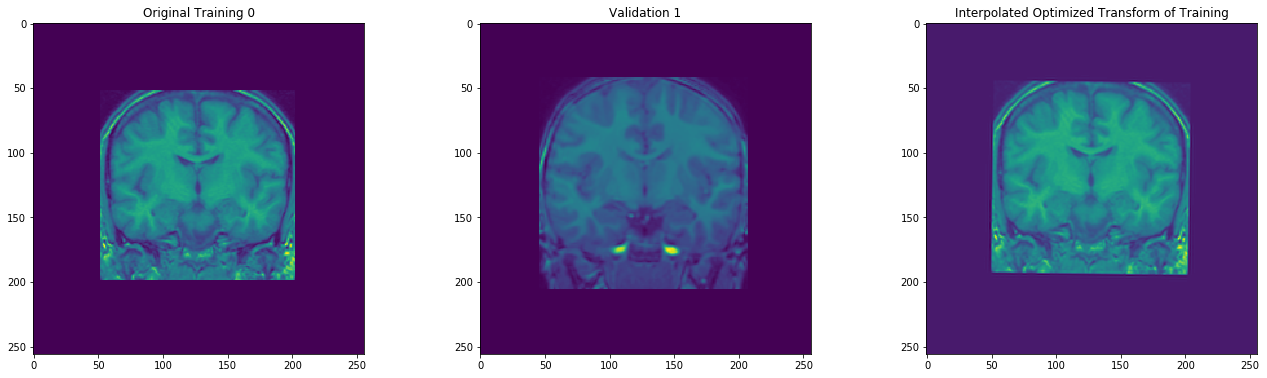

Optimization terminated successfully.
         Current function value: 503.186184
         Iterations: 3
         Function evaluations: 290
[-0.88387551  0.12690121 -0.11211549  3.93263445]


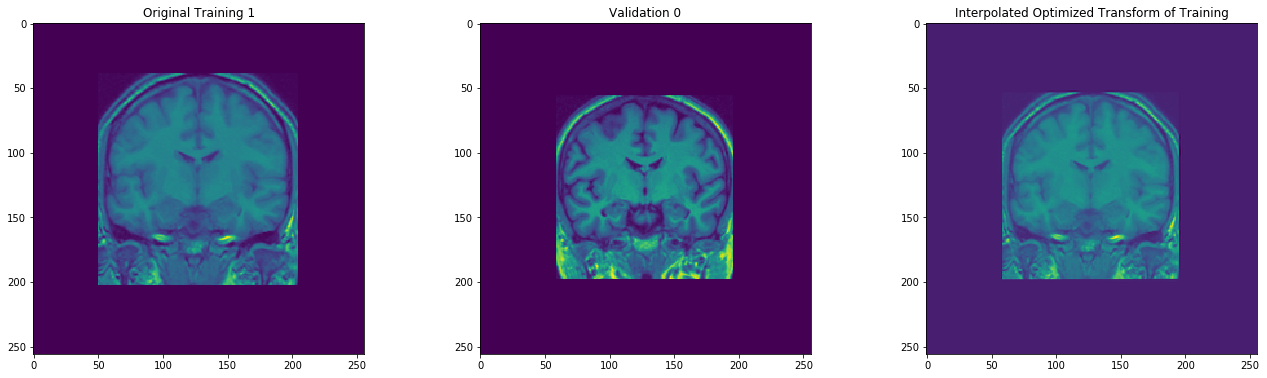

Optimization terminated successfully.
         Current function value: 573.326429
         Iterations: 4
         Function evaluations: 345
[-1.0109523   0.12263916  0.45808512  1.62029229]


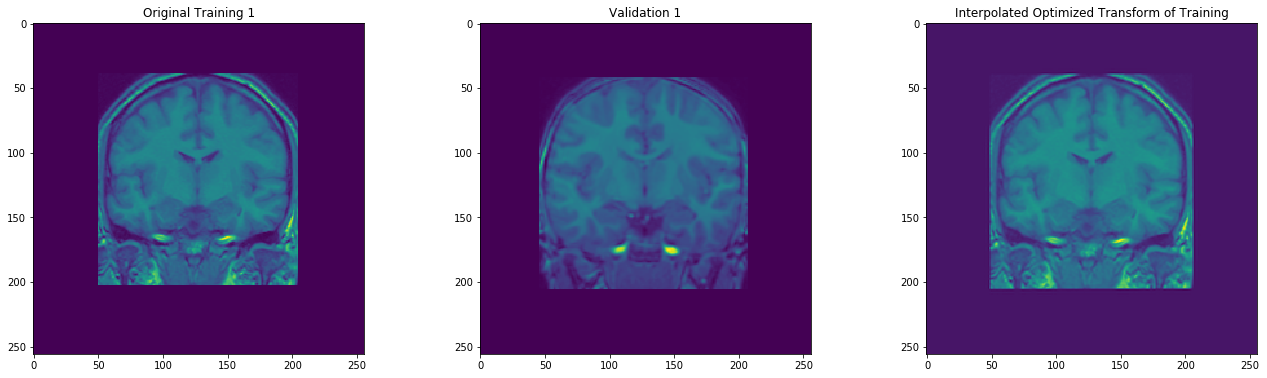

Optimization terminated successfully.
         Current function value: 994.196153
         Iterations: 4
         Function evaluations: 384
[ 0.95505941 -1.3760087  -0.50448727  3.67875831]


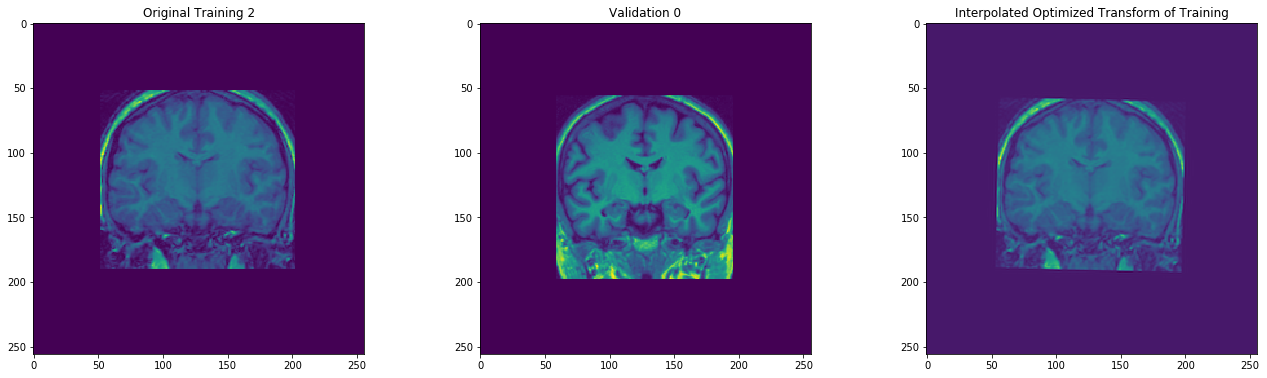

Optimization terminated successfully.
         Current function value: 497.926150
         Iterations: 4
         Function evaluations: 363
[ 1.06242983  0.43917166 -0.60494424  2.49089465]


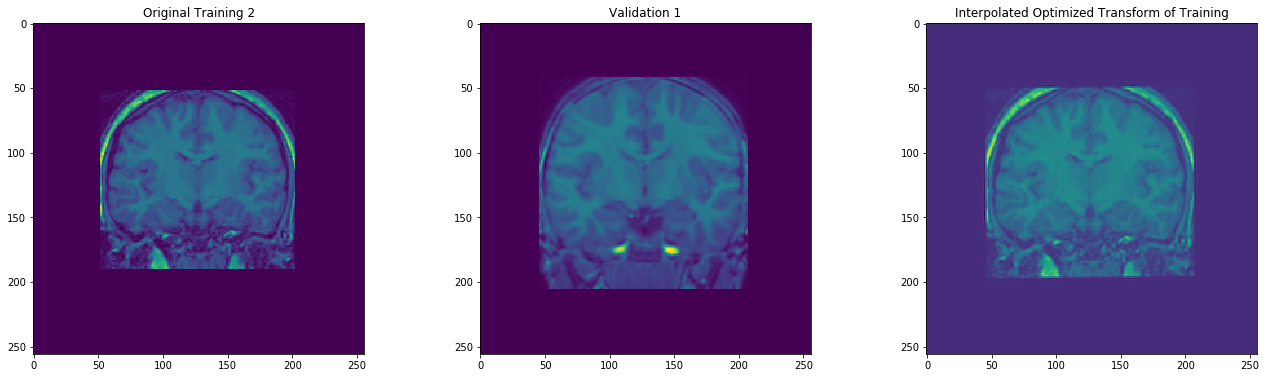

Optimization terminated successfully.
         Current function value: 1100.492269
         Iterations: 6
         Function evaluations: 516
[ 1.00638212  0.4211337  -1.38065406  6.24448646]


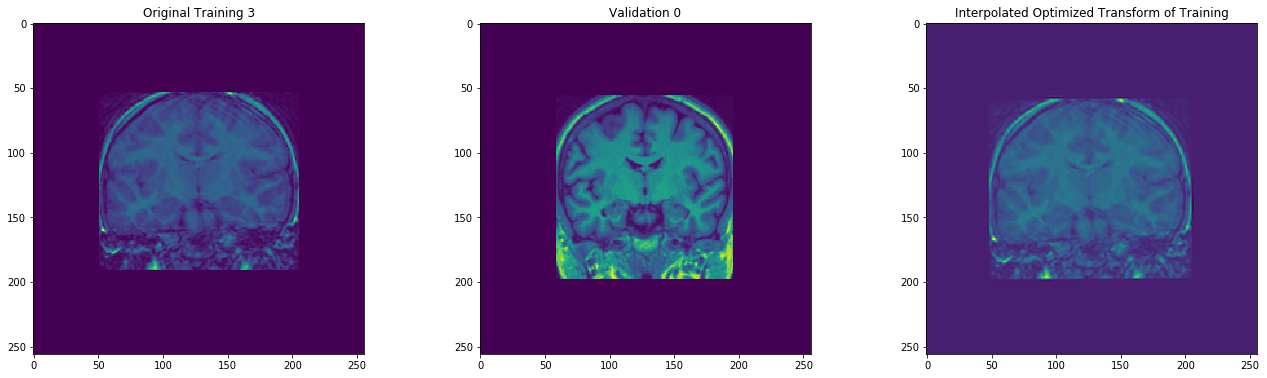

Optimization terminated successfully.
         Current function value: 500.067294
         Iterations: 2
         Function evaluations: 221
[1.08931193 0.10277284 1.24810472 2.440573  ]


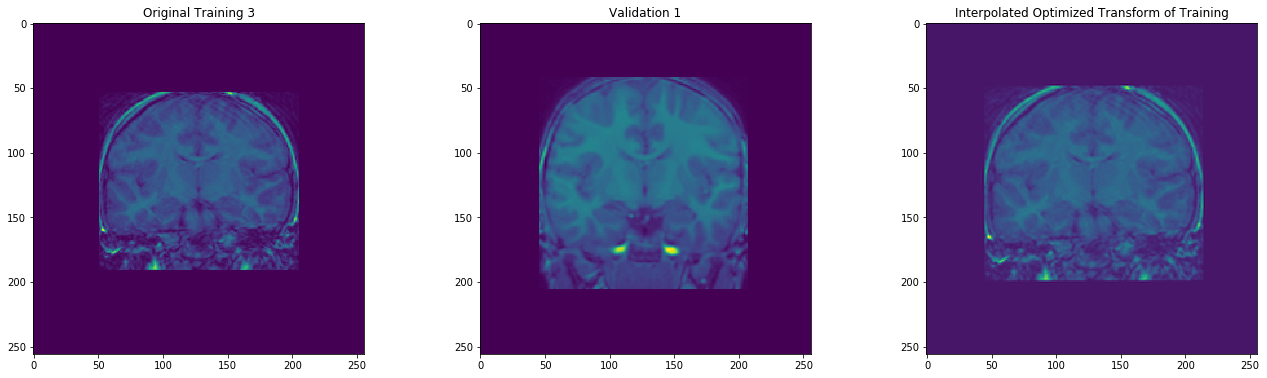

Optimization terminated successfully.
         Current function value: 631.064037
         Iterations: 5
         Function evaluations: 581
[-0.93857883 -0.11949087 -0.46513482  5.95412481]


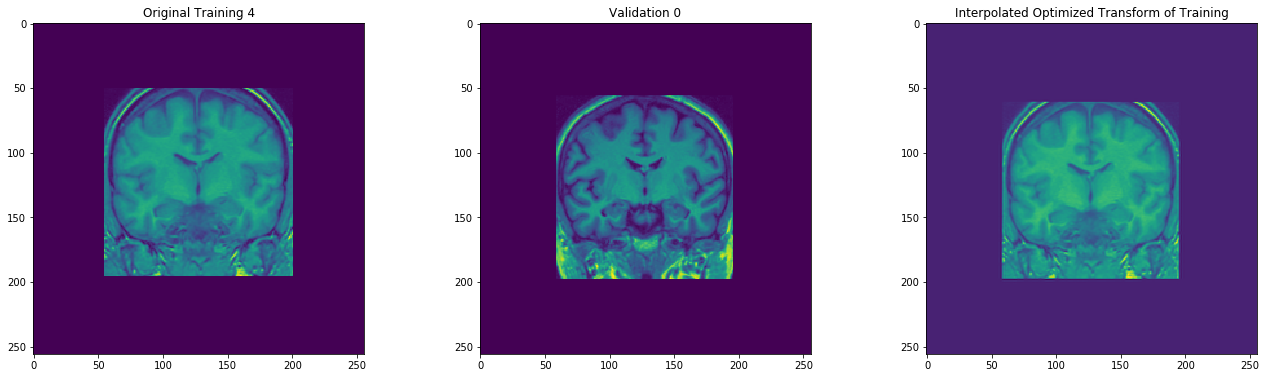

Optimization terminated successfully.
         Current function value: 899.066795
         Iterations: 4
         Function evaluations: 400
[  0.93680478  -3.32096431  -3.47027598 -11.52377725]


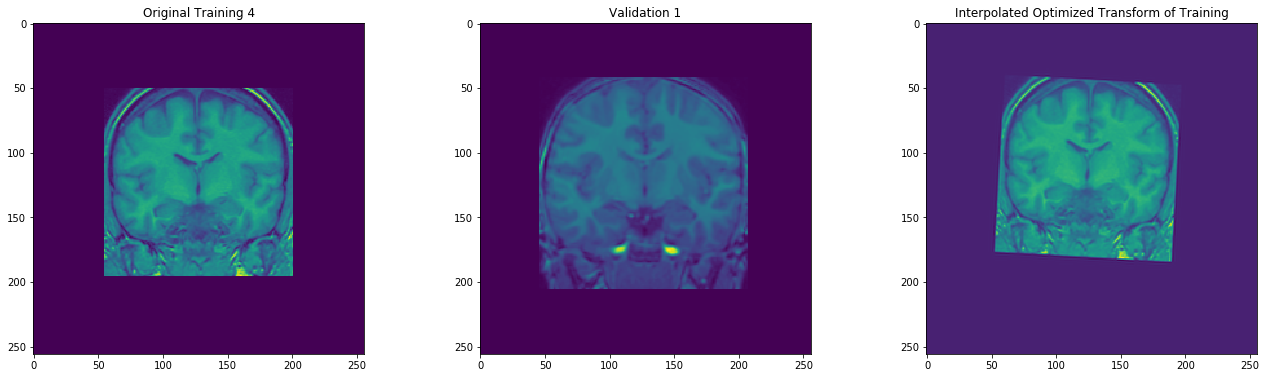

Optimization terminated successfully.
         Current function value: 674.307341
         Iterations: 7
         Function evaluations: 738
[ 0.94491849 -1.80440442  0.36242084  8.28426009]


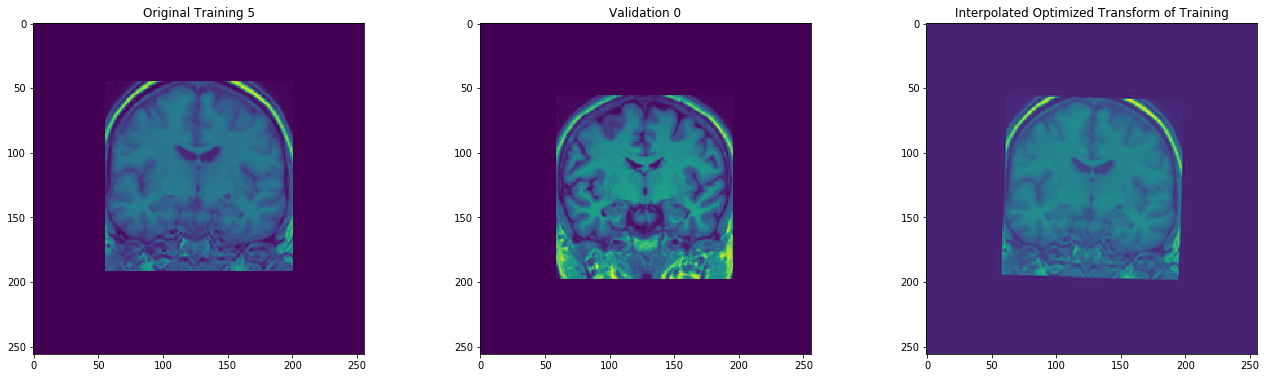

Optimization terminated successfully.
         Current function value: 494.112812
         Iterations: 3
         Function evaluations: 383
[ 1.06103368 -1.81969297  0.47006303  3.51593011]


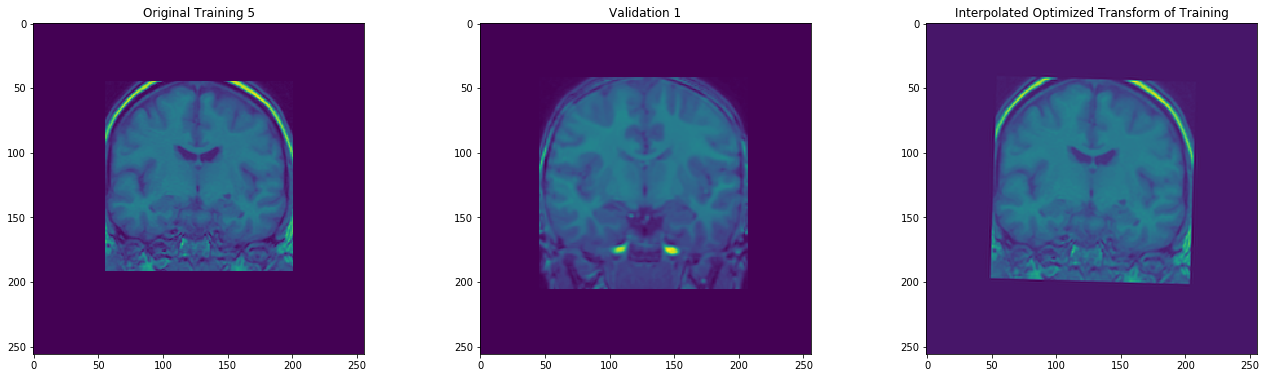

In [76]:
from scipy.interpolate import griddata
% matplotlib inline

init = np.array([1.5,3,1,2])
mapping_segmentations = {}
for i, moving in enumerate(trainings_nonsegs):
    for j, fixed in enumerate(validations_nonsegs):
        
        optimal_transform, params = optimize(normalize(moving),normalize(fixed),initial_guess=init)
        
        # Make gridpoints and interpolate between optimal transform and validation grid
        xx, yy = np.meshgrid(np.arange(fixed.shape[0]),np.arange(fixed.shape[1]),indexing='ij')
        fixedcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
        xx, yy = np.meshgrid(np.arange(optimal_transform.shape[0]),np.arange(optimal_transform.shape[1]),indexing='ij')
        optcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
        a = griddata(points=optcoords,values=optimal_transform.flatten(),xi=fixedcoords,method='nearest').reshape(fixed.squeeze().shape)
        
        mapping_segmentations[(i,j)] = [a, params] # store optimal transform in dict
        #  Plot results
        
        f, axarr = plt.subplots(1,3,figsize=(20,20))
        
        axarr[0].set_title('Original Training %d' %i)
        axarr[0].imshow(moving.squeeze())
        
        axarr[1].set_title('Validation %d' %j)
        axarr[1].imshow(fixed.squeeze())
    
#         axarr[2].set_title('Optimized Transformed')
#         axarr[2].imshow(optimal_transform)
    
        axarr[2].set_title('Interpolated Optimized Transform of Training')
        axarr[2].imshow(a)        
        plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)
        plt.show()

        

## Majority Voting Based Label Fusion

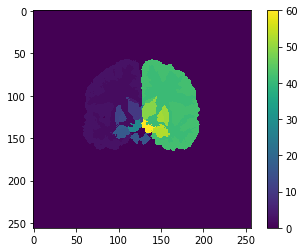

In [77]:
% matplotlib inline
# Majority based labeling 
from scipy.stats import mode
# Ties broken by choosing smaller label (default scipy operation)

def majority_fusion(segs_list):
    votes = mode(np.dstack(segs_list),axis=2)
    return votes[0].squeeze()

training_majority_labs = majority_fusion(trainings_segs)
plt.imshow(training_majority_labs)
plt.colorbar()



## Jaccard Overlap Calculation for each Registration

Computing Jaccard Overlap for Left White Matter

0 2


C:\Users\shubh\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


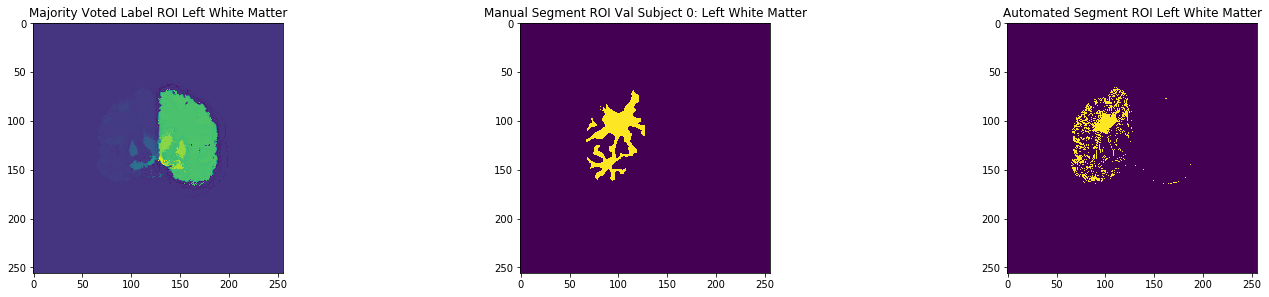

Jaccard Overlap:  0.26612605971249537
1 2


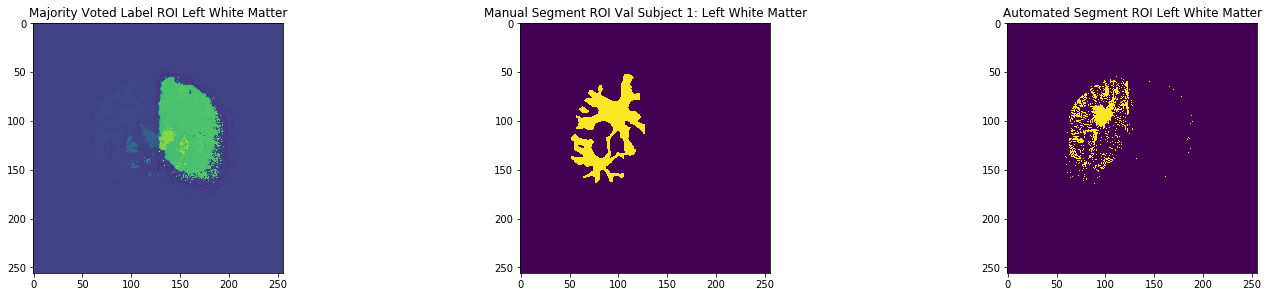

Jaccard Overlap:  0.23014668689934245
Computing Jaccard Overlap for Left Cerebral Cortex

0 3


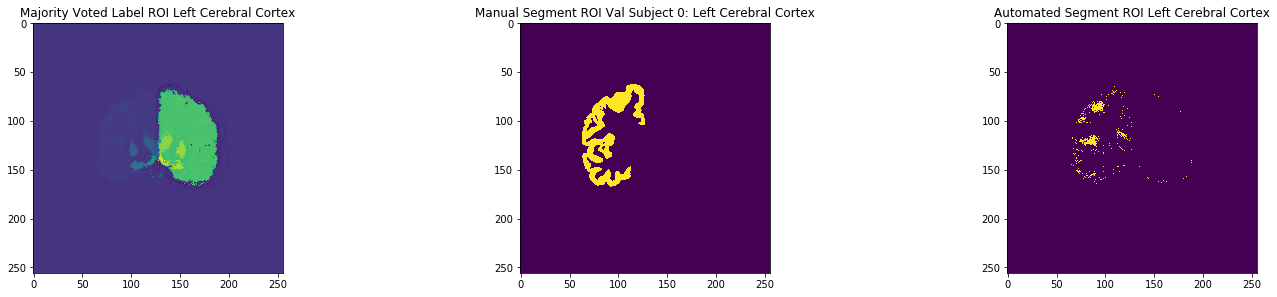

Jaccard Overlap:  0.11097708082026538
1 3


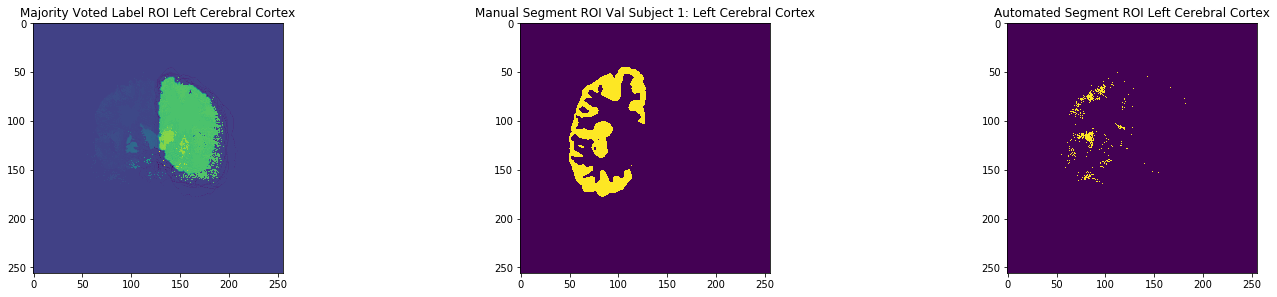

Jaccard Overlap:  0.07157569515962925
Computing Jaccard Overlap for Right White Matter

0 41


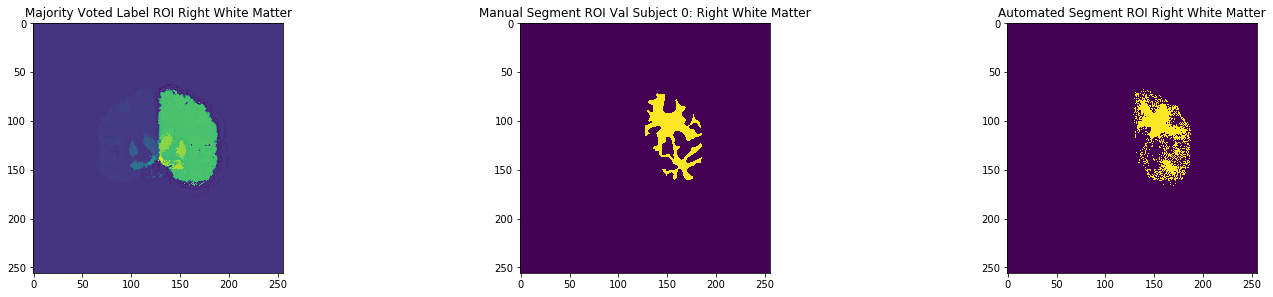

Jaccard Overlap:  0.4692113791861721
1 41


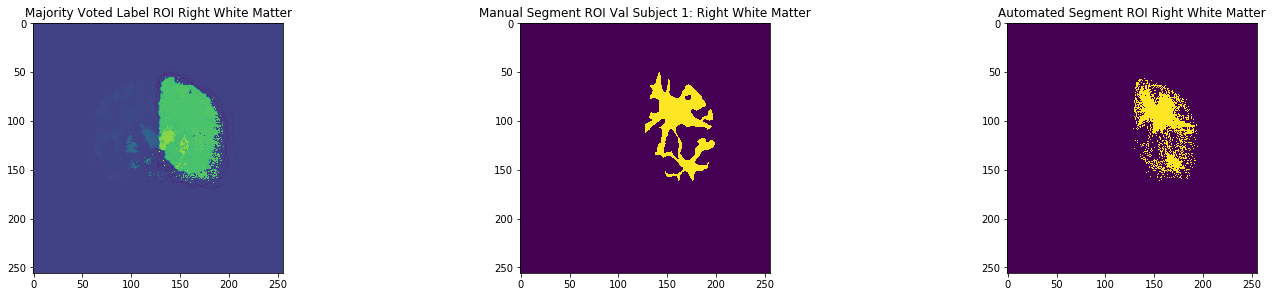

Jaccard Overlap:  0.42651673640167365
Computing Jaccard Overlap for Right Cerebral Cortex

0 42


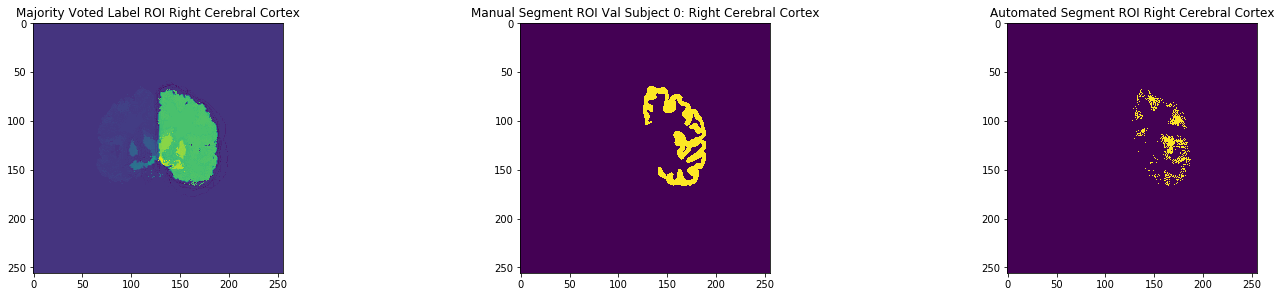

Jaccard Overlap:  0.239430724152365
1 42


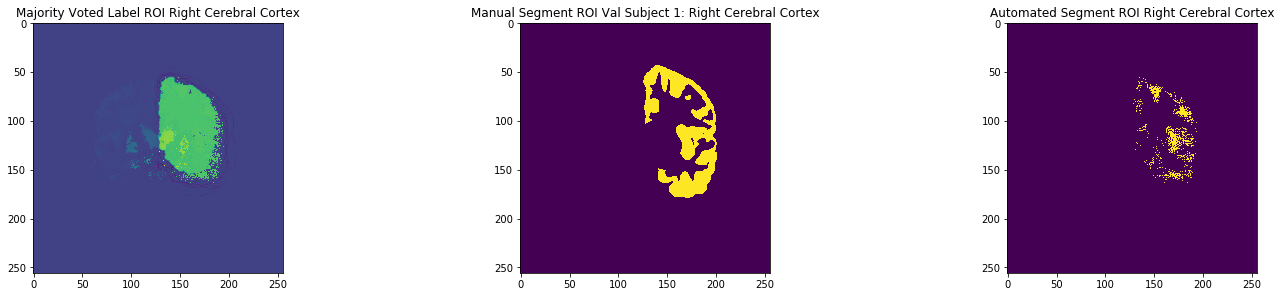

Jaccard Overlap:  0.12496966755641835


In [78]:
% matplotlib inline
table = []
label_dict = {2:'Left White Matter', 3:'Left Cerebral Cortex', 41:'Right White Matter',42:'Right Cerebral Cortex'}
for label in list(label_dict.keys()):
    print ('Computing Jaccard Overlap for %s\n======================================\n'%label_dict[label])
    for valid in range(len(validations_segs)):
        manualcopy = np.copy(validations_segs[valid].squeeze())
        autocopy = np.zeros_like(manualcopy)
        segment_transforms = []
        for mapping, automatic_seg in mapping_segmentations.items():  #mapping [0] is training, mapping [1] is valid
            if mapping[1] == valid: 
                params = automatic_seg[1]
                p = np.max(trainings_segs[mapping[0]])  # used for reversing effect of normalization 
                seg_transform = p * geometric_transform(trainings_segs[mapping[0]].squeeze(),
                                                        params[0],
                                                        params[1],
                                                        params[2],
                                                        params[3],
                                                        trainings_segs[mapping[0]].shape)[1].astype(np.float16)
                segment_transforms.append(seg_transform)
            
        voted = majority_fusion(segment_transforms).astype(np.int16)
        autocopy[np.where(voted == label)] = 1
        autocopy[np.where(autocopy != 1)] = 0
        manualcopy[np.where(manualcopy == label)] = 1
        manualcopy[np.where(manualcopy != 1)] = 0
        assert autocopy.shape == manualcopy.shape and manualcopy.shape == voted.shape

        f, axarr = plt.subplots(1,3,figsize=(20,20))
        
        axarr[0].set_title('Majority Voted Label ROI %s'%label_dict[label])
        s = axarr[0].imshow(voted)  
        axarr[1].set_title('Manual Segment ROI Val Subject %d: %s'%(valid,label_dict[label]))
        axarr[1].imshow(manualcopy)
        axarr[2].set_title('Automated Segment ROI %s'%label_dict[label])
        axarr[2].imshow(autocopy)  
        plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.95)
        plt.plot()
        plt.show()
        jac = jaccard(manualcopy,autocopy)
        print ('Jaccard Overlap: ', jac)
        manualcopy = np.zeros_like(autocopy)
        table.append([valid,label_dict[label],jac]) #  validation subjects x labels


In [79]:
import pandas as pd
table = pd.DataFrame(table,columns=['Validation Subject','ROI(label)','Jaccard Score'])
print (table)

   Validation Subject             ROI(label)  Jaccard Score
0                   0      Left White Matter       0.266126
1                   1      Left White Matter       0.230147
2                   0   Left Cerebral Cortex       0.110977
3                   1   Left Cerebral Cortex       0.071576
4                   0     Right White Matter       0.469211
5                   1     Right White Matter       0.426517
6                   0  Right Cerebral Cortex       0.239431
7                   1  Right Cerebral Cortex       0.124970
